## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [82]:
%matplotlib inline
from time import time, sleep
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
sns.set()
from IPython import display
from IPython.display import clear_output

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [37]:
# (re-)load layers
%run modules_new-9.py

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

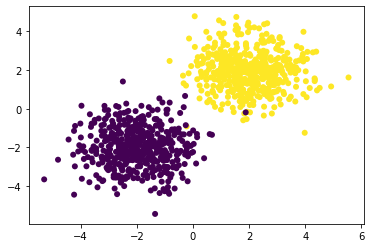

In [38]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [91]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [40]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [41]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

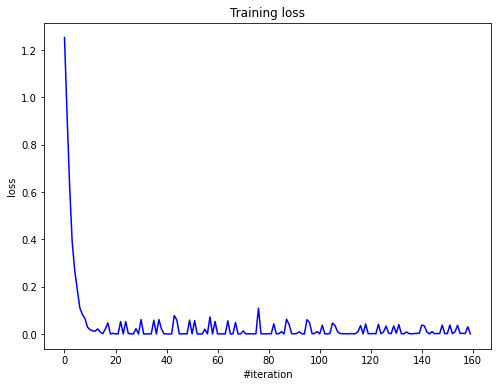

Current loss: 0.000623


In [42]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [53]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [89]:
# Your code goes here. ################################################
def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)] = 1.
    return y_one_hot

In [90]:
n_classes = len(set(y_train))
input_shape = X_train.shape[1] * X_train.shape[2]
y_train_one_hot = one_hot_encode(n_classes, y_train)
y_val_one_hot = one_hot_encode(n_classes, y_val)
y_test_one_hot = one_hot_encode(n_classes, y_test)
print(y_test)
print(y_test_one_hot)

[7 2 1 ... 4 5 6]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [65]:
# Your code goes here. ################################################
net_relu = Sequential()
net_relu.add(Linear(input_shape, 256))
net_relu.add(ReLU())
net_relu.add(Linear(256, n_classes))
net_relu.add(LogSoftMax())

net_elu = Sequential()
net_elu.add(Linear(input_shape, 256))
net_elu.add(ELU())
net_elu.add(Linear(256, n_classes))
net_elu.add(LogSoftMax())

net_lrelu = Sequential()
net_lrelu.add(Linear(input_shape, 256))
net_lrelu.add(LeakyReLU())
net_lrelu.add(Linear(256, n_classes))
net_lrelu.add(LogSoftMax())

net_softplus = Sequential()
net_softplus.add(Linear(input_shape, 256))
net_softplus.add(SoftPlus())
net_softplus.add(Linear(256, n_classes))
net_softplus.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_relu)
print(net_elu)
print(net_lrelu)
print(net_softplus)

Linear 784 -> 256
ReLU
Linear 256 -> 10
LogSoftMax

Linear 784 -> 256
ELU
Linear 256 -> 10
LogSoftMax

Linear 784 -> 256
LeakyReLU
Linear 256 -> 10
LogSoftMax

Linear 784 -> 256
SoftPlus
Linear 256 -> 10
LogSoftMax



In [66]:
def train_model(net, X_train, y_train, X_val, y_val, batch_size, n_epoch, optimizer, opt_config):
    loss_history = []
    val_loss_history = []
    val_accuracy = []
    optimizer_state = {}
    for i in range(n_epoch):
        net.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            x_batch = x_batch.reshape((x_batch.shape[0], x_batch.shape[1]*x_batch.shape[2]))
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss_train = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(), 
                      net.getGradParameters(), 
                      opt_config,
                      optimizer_state)      

            loss_history.append(loss_train)

        ## Validation
        net.evaluate()
        correct = 0
        total = 0
        for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
            x_batch = x_batch.reshape((x_batch.shape[0], x_batch.shape[1]*x_batch.shape[2]))
            out = net.forward(x_batch)
            loss_val = criterion.forward(out, y_batch)  
            y_pred = np.argmax(out, axis=1)
            correct += np.sum(y_pred == np.argmax(y_batch, axis=1)) 
            total += len(y_batch)       
            val_loss_history.append(loss_val)
            
        val_accuracy.append(correct/total)
        # Visualize
        display.clear_output(wait=True)

        print('Train loss: %f' % loss_train)
        print('Validation loss: %f' % loss_val)
        print('Accuracy val: %f', correct/total)
        return loss_history, val_loss_history, val_accuracy

In [ ]:
## test


In [67]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

In [68]:
def test_model(net, X_test, y_test, batch_size):
    test_accuracy = []
    optimizer_state = {}
    net.evaluate()
    correct = 0
    total = 0
    for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
        x_batch = x_batch.reshape((x_batch.shape[0], x_batch.shape[1]*x_batch.shape[2]))
        out = net.forward(x_batch)
        y_pred = np.argmax(out, axis=1)
        correct += np.sum(y_pred == np.argmax(y_batch, axis=1)) 
        total += len(y_batch)       
            
    test_accuracy.append(correct/total)
    print('Accuracy test: %f', correct/total)

In [69]:
opt_config_sgd = {'learning_rate' : 1e-1, 'momentum': 0.9}
opt_config_adam = {'learning_rate': 1e-1, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-7}

In [70]:
n_epochs = 5
print("ReLU")
test_loss, val_loss, val_acc = train_model(net_relu, X_train, y_train_one_hot, X_val, y_val_one_hot, batch_size, n_epochs, optimizer=sgd_momentum, opt_config=opt_config_sgd)

Train loss: 0.100576
Validation loss: 0.094000
Accuracy val: %f 0.9653


In [71]:
print("ReLU")
test_model(net_relu, X_test, y_test_one_hot, batch_size)

ReLU
Accuracy test: %f 0.9632


In [ ]:
n_epochs = 5
print("ELU")
test_loss, val_loss, val_acc = train_model(net_elu, X_train, y_train_one_hot, X_val, y_val_one_hot, batch_size, n_epochs, sgd_momentum, opt_config_sgd)

ELU


NameError: ignored

In [ ]:
print("ELU")
test_model(net_elu, X_test, y_test_one_hot, batch_size)

ELU


NameError: ignored

In [92]:
n_epochs = 5
print("LeakyReLU")
test_loss, val_loss, val_acc = train_model(net_lrelu, X_train, y_train_one_hot, X_val, y_val_one_hot, batch_size, n_epochs, sgd_momentum, opt_config_sgd)

Train loss: 0.209349
Validation loss: 0.276672
Accuracy val: %f 0.9606


In [ ]:
print("LeakyReLU")
test_model(net_lrelu, X_test, y_test_one_hot, batch_size)

LeakyReLU
Accuracy test: %f 0.9579


In [ ]:
n_epochs = 5
print("SortPlus")
test_loss, val_loss, val_acc = train_model(net_softplus, X_train, y_train_one_hot, X_val, y_val_one_hot, batch_size, n_epochs, sgd_momentum, opt_config_sgd)

Train loss: 0.126124
Validation loss: 0.465159
Accuracy val: %f 0.9342


In [ ]:
print("SoftPlus")
test_model(net_softplus, X_test, y_test_one_hot, batch_size)

SoftPlus
Accuracy test: %f 0.9275


In [ ]:
net_relu1 = Sequential()
net_relu1.add(Linear(input_shape, 256))
net_relu1.add(ReLU())
net_relu1.add(BatchNormalization(0.9))
net_relu1.add(ChannelwiseScaling(256))
net_relu1.add(Linear(256, n_classes))
net_relu1.add(LogSoftMax())

net_elu1 = Sequential()
net_elu1.add(Linear(input_shape, 256))
net_elu1.add(BatchNormalization(0.9))
net_elu1.add(ChannelwiseScaling(256))
net_elu1.add(ELU())
net_elu1.add(Linear(256, n_classes))
net_elu1.add(LogSoftMax())

net_lrelu1 = Sequential()
net_lrelu1.add(Linear(input_shape, 256))
net_lrelu1.add(BatchNormalization(0.9))
net_lrelu1.add(ChannelwiseScaling(256))
net_lrelu1.add(LeakyReLU())
net_lrelu1.add(Linear(256, n_classes))
net_lrelu1.add(LogSoftMax())

net_softplus1 = Sequential()
net_softplus1.add(Linear(input_shape, 256))
net_softplus1.add(BatchNormalization(0.9))
net_softplus1.add(ChannelwiseScaling(256))
net_softplus1.add(SoftPlus())
net_softplus1.add(Linear(256, n_classes))
net_softplus1.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net_relu1)
print(net_elu1)
print(net_lrelu1)
print(net_softplus1)

Linear 784 -> 256
ReLU
BatchNormalization
ChannelwiseScaling
Linear 256 -> 10
LogSoftMax

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
ELU
Linear 256 -> 10
LogSoftMax

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 256 -> 10
LogSoftMax

Linear 784 -> 256
BatchNormalization
ChannelwiseScaling
SoftPlus
Linear 256 -> 10
LogSoftMax



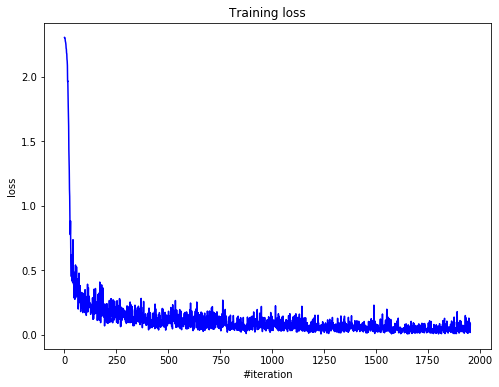

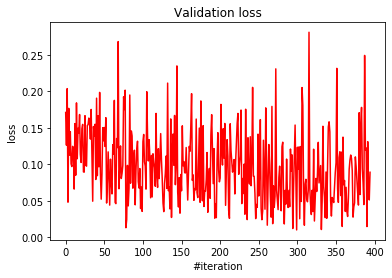

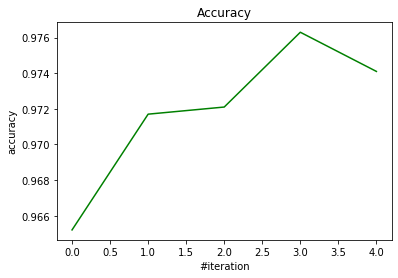

Train loss: 0.080640
Validation loss: 0.089044
Accuracy val: %f 0.9741
Accuracy test: %f 0.9746


In [ ]:
n_epochs = 5
print("ReLU")
train_model(net_relu1, X_train, y_train_one_hot, X_val, y_val_one_hot, batch_size, n_epochs)
test_model(net_relu1, X_test, y_test_one_hot, batch_size)

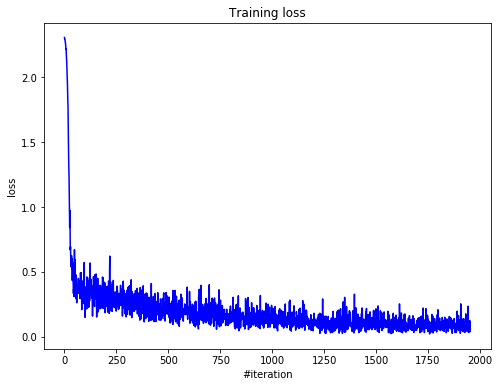

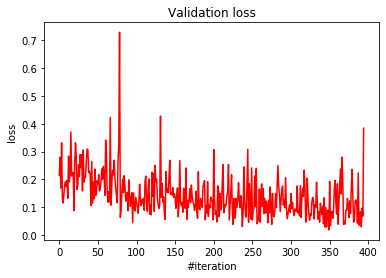

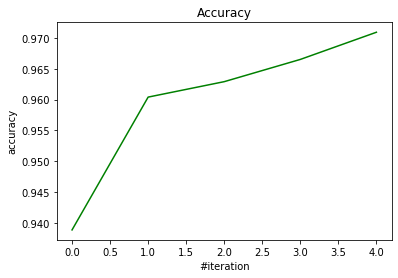

Train loss: 0.060101
Validation loss: 0.384281
Accuracy val: %f 0.9709
Accuracy test: %f 0.9701


In [ ]:
n_epochs = 5
print("ELU")
train_model(net_elu1, X_train, y_train_one_hot, X_val, y_val_one_hot, batch_size, n_epochs)
test_model(net_elu1, X_test, y_test_one_hot, batch_size)

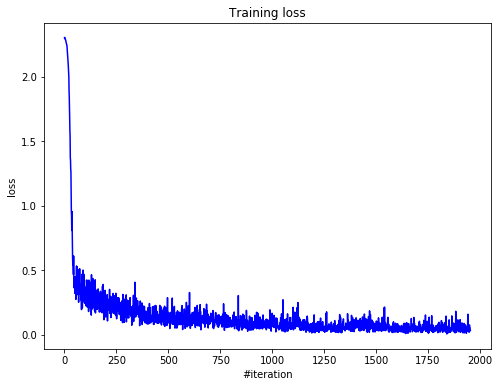

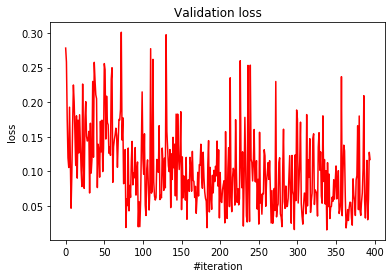

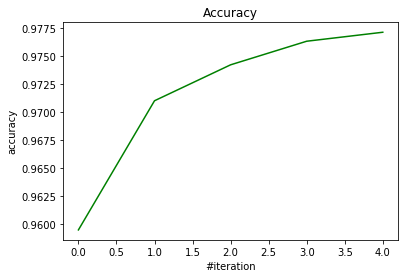

Train loss: 0.031044
Validation loss: 0.117239
Accuracy val: %f 0.9771
Accuracy test: %f 0.9743


In [ ]:
n_epochs = 5
print("LeakyReLU")
train_model(net_lrelu1, X_train, y_train_one_hot, X_val, y_val_one_hot, batch_size, n_epochs)
test_model(net_lrelu1, X_test, y_test_one_hot, batch_size)

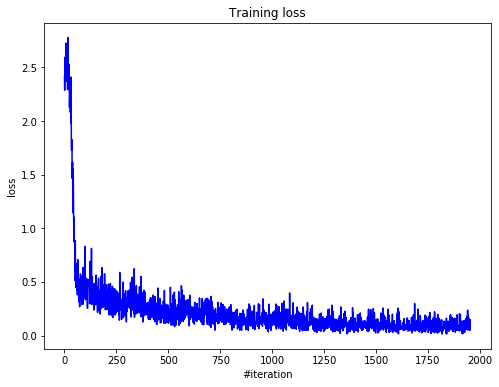

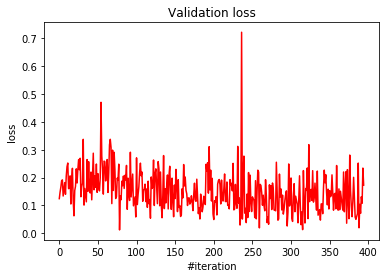

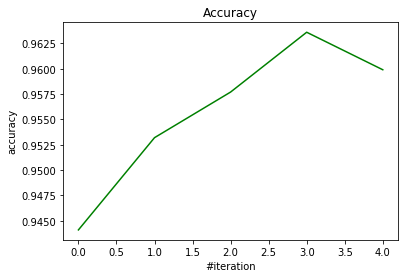

Train loss: 0.146584
Validation loss: 0.172917
Accuracy val: %f 0.9599
Accuracy test: %f 0.9596


In [ ]:
n_epochs = 5
print("SoftPlus")
train_model(net_softplus1, X_train, y_train_one_hot, X_val, y_val_one_hot, batch_size, n_epochs)
test_model(net_softplus1, X_test, y_test_one_hot, batch_size)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [ ]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [88]:
X_train_conv = X_train[:, None, :, :]
X_val_conv = X_val[:, None, :, :]
X_test_conv = X_test[:, None, :, :]

In [ ]:
from tqdm import tqdm

def train_model_conv(net, X_train, y_train, X_val, y_val, batch_size, n_epoch, optimizer, opt_config):
    loss_history = []
    val_loss_history = []
    val_accuracy = []
    optimizer_state = {}
    for i in range(n_epoch):
        net.train()
        for x_batch, y_batch in tqdm(get_batches((X_train, y_train), batch_size)):
            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss_train = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer(net.getParameters(), 
                      net.getGradParameters(), 
                      opt_config,
                      optimizer_state)      

            loss_history.append(loss_train)

        ## Validation
        net.evaluate()
        correct = 0
        total = 0
        for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
            out = net.forward(x_batch)
            loss_val = criterion.forward(out, y_batch)  
            y_pred = np.argmax(out, axis=1)
            correct += np.sum(y_pred == np.argmax(y_batch, axis=1)) 
            total += len(y_batch)       
            val_loss_history.append(loss_val)
            
        val_accuracy.append(correct/total)
        # Visualize
        display.clear_output(wait=True)

        print('Train loss: %f' % np.mean(loss_train))
        print('Validation loss: %f' % np.mean(loss_val))
        print('Accuracy val: %f', correct/total)
    return loss_history, val_loss_history, val_accuracy

In [ ]:
best_net = Sequential()
best_net.add(Conv2d(1, 16, 3))
best_net.add(ReLU())
best_net.add(MaxPool2d(2))
best_net.add(Conv2d(16, 32, 3))
best_net.add(ReLU())
best_net.add(MaxPool2d(2))
best_net.add(BatchNormalization(0.9))
best_net.add(ChannelwiseScaling(32))
best_net.add(Flatten())
best_net.add(Linear(1568, n_classes))
best_net.add(SoftMax())

# optimizer = adam_optimizer()

In [ ]:
# Your code goes here. ################################################
n_epochs = 5
loss_history, val_loss_history, val_accuracy = train_model_conv(best_net, X_train_conv,
                                                                y_train_one_hot, X_val_conv,
                                                                y_val_one_hot, batch_size,
                                                                n_epochs, optimizer=adam_optimizer,
                                                                opt_config=opt_config_adam)

Train loss: -0.824999
Validation loss: -0.875000
Accuracy val: %f 0.8495


In [ ]:
loss_history_for_plot = [loss_history[i] for i in np.linspace(0, len(loss_history)-1,
                                                              len(val_loss_history),
                                                              dtype=np.int)]

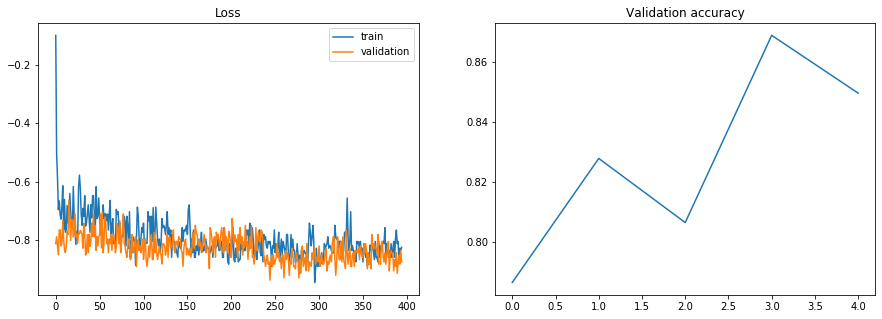

In [ ]:
plot_train_process(loss_history_for_plot, val_loss_history, val_accuracy)

In [ ]:
best_net = Sequential()
best_net.add(Conv2d(1, 16, 3))
best_net.add(MaxPool2d(2))
best_net.add(ReLU())
best_net.add(Conv2d(16, 1, 3))
best_net.add(MaxPool2d(2))
best_net.add(ReLU())
best_net.add(Flatten())
best_net.add(Linear(49, n_classes))
best_net.add(SoftMax())

In [ ]:
n_epochs = 5
loss_history, val_loss_history, val_accuracy = train_model_conv(best_net, X_train_conv,
                                                                y_train_one_hot, X_val_conv,
                                                                y_val_one_hot, batch_size,
                                                                n_epochs, optimizer=adam_optimizer,
                                                                opt_config=opt_config_adam)

Train loss: -0.087504
Validation loss: -0.062511
Accuracy val: %f 0.1064


Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################
test_model(best_net, X_test, y_test_one_hot, batch_size)

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [72]:
def train_epoch_v3(model, 
                   data, 
                   batch_size, 
                   criterion, 
                   optimizer=None, 
                   optimizer_params=None, 
                   is_train=True):
    '''
    Одна эпоха обучения / валидации
    '''
    epoch_loss = 0.0
    corrects = 0.0
    
    model.train(is_train)
    
    for x_batch, y_batch in get_batches(data, batch_size):
        
        x_batch = torch.FloatTensor(x_batch)
        y_batch = torch.FloatTensor(y_batch)
        
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch.argmax(axis=1))
        
        if is_train:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss += loss * x_batch.size(0)
        corrects += (predictions.argmax(dim=1) == y_batch.argmax(dim=1)).sum()
        
    return epoch_loss / data[0].shape[0], corrects / data[0].shape[0]

In [86]:
def train_v3(model, 
             train_data, 
             val_data, 
             n_epochs, 
             batch_size, 
             optimizer,
             criterion, 
             scheduler=None):
    '''
  
    '''
    train_losses = []
    val_losses = []
    
    train_acc = []
    val_acc = []
    
    for _ in range(n_epochs):
        # train
        loss, acc = train_epoch_v3(model, 
                                train_data, 
                                batch_size, 
                                criterion,
                                optimizer)
        train_losses.append(loss)
        train_acc.append(acc)
            
        # val
        loss, acc = train_epoch_v3(model, 
                                   val_data, 
                                   batch_size,
                                   criterion, 
                                   is_train=False)
        

        val_losses.append(loss)
        val_acc.append(acc)
    
        if scheduler is not None:
            scheduler.step()

        clear_output()
        
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 2, 1)
        plt.title('Loss', fontsize=15)
        plt.xlabel("Эпоха", fontsize=15)
        plt.ylabel("Лосс", fontsize=15)
        plt.plot(train_losses, label='train', linewidth=3)
        plt.plot(val_losses, label='val', linewidth=3)
        plt.legend(fontsize=10)
        
        plt.subplot(1, 2, 2)
        plt.title('Accuracy', fontsize=15)
        plt.xlabel("Эпоха", fontsize=15)
        plt.ylabel("Accuracy", fontsize=15)
        plt.plot(train_acc, label='train', linewidth=3)
        plt.plot(val_acc, label='val', linewidth=3)
        plt.legend(fontsize=10)
        
        plt.show()

In [85]:
class MyModelTorch(nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(),
            nn.Linear(10, 20),
            nn.BatchNorm1d(20),
            nn.LeakyReLU(),
            nn.Linear(20, 10),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LogSoftmax()                      
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [84]:
model = MyModelTorch()
model

MyModelTorch(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=10, out_features=20, bias=True)
    (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=20, out_features=10, bias=True)
    (8): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): LogSoftmax(dim=None)
  )
)